# Read, format, and write data with Pandas

Pretty much every analysis workflow can be thought of as three steps -- read data, format it so that you can extract whatever info you need, and export that info for others or future use. We'll use ERCOT electrical grid load data to highlight how Pandas can make this workflow straightforward. 

**Notebook goals:**
- Understand Pandas built-in IO functions, particularly for excel spreadsheets
- Define a dataframe index and understand its value
- Extract subsets of data from an existing dataframe based off user-defined criteria, and rename or format data for preference
- Plot dataframe columns
- Save analysis results as an excel spreadsheet

https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

# update plot defaults:
plt.rcParams.update(
    {"font.size": 8, 
     "figure.figsize": (6,4),
    "lines.linewidth": 3})

## Read tabular data

Let's play around with data from our favorite Texas energy utility -- ERCOT. Plenty of tabular data is available on their website. Let's take one of their simpler spreadsheets as an example. Historical ERCOT grid loads per hour data for this and previous years is available at the link below:

http://www.ercot.com/gridinfo/load/load_hist

We pulled the 2021 ERCOT hourly load data and saved it to a spreadsheet. Let's read this data in with Pandas.

In [2]:
data = pd.read_excel("data/ercot-load-2021.xlsx")

# view the first five rows with head():
data.head()

,Hour Ending,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
0,01/01/2021 01:00,11047.018793,1517.435253,3978.220628,838.352810,13575.277728,3545.093310,7778.262533,1440.188560,43719.849616
1,01/01/2021 02:00,10954.470339,1523.683893,3975.757045,825.123437,13340.337915,3586.547882,7693.744119,1421.385715,43321.050347
2,01/01/2021 03:00,10883.657240,1519.800916,3969.812081,819.551228,13311.625189,3586.124059,7566.951524,1405.544826,43063.067063
3,01/01/2021 04:00,10926.482445,1523.472963,3983.487761,820.612439,13356.442066,3570.592369,7506.685527,1402.283632,43090.059203
4,01/01/2021 05:00,11019.796399,1565.625573,3980.940744,831.607158,13528.651487,3590.902242,7563.971854,1405.094618,43486.590073


In [3]:
# round the values to two digits:
data.round(2).head()

,Hour Ending,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
0,01/01/2021 01:00,11047.02,1517.44,3978.22,838.35,13575.28,3545.09,7778.26,1440.19,43719.85
1,01/01/2021 02:00,10954.47,1523.68,3975.76,825.12,13340.34,3586.55,7693.74,1421.39,43321.05
2,01/01/2021 03:00,10883.66,1519.80,3969.81,819.55,13311.63,3586.12,7566.95,1405.54,43063.07
3,01/01/2021 04:00,10926.48,1523.47,3983.49,820.61,13356.44,3570.59,7506.69,1402.28,43090.06
4,01/01/2021 05:00,11019.80,1565.63,3980.94,831.61,13528.65,3590.90,7563.97,1405.09,43486.59


The data we read in is exactly the same as the spreadsheet. We can get an idea of its shape and what it contains pretty easily using builtin dataframe attributes.

In [4]:
data.shape

(1416, 10)

In [5]:
for col in data.columns:
    print(col)

Hour Ending
COAST
EAST
FWEST
NORTH
NCENT
SOUTH
SCENT
WEST
ERCOT


These correspond to the ERCOT weather zones, shown below. 

![alt text](ercot-regions.png "ERCOT weather regions.")

Let's extract the data we care about:
- Houston area electrical loads
- total loads for the state

Houston is in the "COAST" region, so we'll keep that column as well as the total "ERCOT" column. Let's then rename the columns to something that is more intuitive.

In [6]:
columns_of_interest = [
    "Hour Ending",
    "COAST",
    "ERCOT",
    ]
data = data.loc[:, columns_of_interest]

# rename columns:
old2new_cols = {
    "Hour Ending": "day_and_hour",
    "COAST": "houston_area", #includes Galvaston, etc
    "ERCOT": "total",
    }
data = data.rename(columns=old2new_cols)
data.head()

,day_and_hour,houston_area,total
0,01/01/2021 01:00,11047.018793,43719.849616
1,01/01/2021 02:00,10954.470339,43321.050347
2,01/01/2021 03:00,10883.657240,43063.067063
3,01/01/2021 04:00,10926.482445,43090.059203
4,01/01/2021 05:00,11019.796399,43486.590073


## Plot tabular data

The data we read in is exactly the same as the spreadsheet. Now, let's plot it. 

Text(0, 0.5, 'MegaWatts')

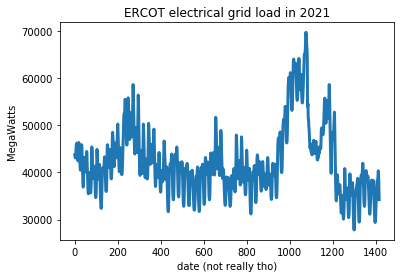

In [7]:
plt.figure()
plt.title("ERCOT electrical grid load in 2021")
plt.plot(data.total)
plt.xlabel("date (not really tho)")
plt.ylabel("MegaWatts")

## Write tabular data

Let's extract the available February 2021 data and save it as an excel file for later use. We can do this in a variety of ways:
- eyeball the spreadsheet and simply copy the relevant rows into a new spreadsheet. This assumes the data is in temporal order, which is not always the case. 
- iterate over each row, keep the row if that row's date column is within February, and discard the row if not. This is time consuming though, and memory intensive if the dataset grows large. 

Instead, we can use Pandas to easily slice out what we need. First we must do the following steps to our dataset:
- Convert the "Hour Ending" column data into datetime objects
- Make the "Hour Ending" column the dataset's index
- slice out our desired time range

In [8]:
# ERCOT delivers hours from 01-24, not 00-23; this 
# does not make any sense and goes against convention.
# we'll have to convert the datetime strings back
# to conventional expressions before we convert
# to datetime objects.
def convention(x):
    s1 = x.split(":")[0][-2:]
    s2 = int(s1) - 1
    if s2 < 10:
        s3 = "0%d" %s2
    else:
        s3 = "%d" %s2
    date = x.split(" ")[0]
    return "%s %s:00" %(date,s3)

# apply convention conversion:
data.loc[:,"day_and_hour"] = data.day_and_hour.apply(convention)

# now convert to datetime:
data.loc[:,"day_and_hour"] = pd.to_datetime(
    data["day_and_hour"],
    format="%m/%d/%Y %H:%M"
    )

# set index as datetime:
data = data.set_index(["day_and_hour"], drop=True)

# display:
data.round(2).head()

,houston_area,total
day_and_hour,,
2021-01-01 00:00:00,11047.02,43719.85
2021-01-01 01:00:00,10954.47,43321.05
2021-01-01 02:00:00,10883.66,43063.07
2021-01-01 03:00:00,10926.48,43090.06
2021-01-01 04:00:00,11019.80,43486.59


We can now easily extract the February data:

In [9]:
feb = data.loc["2021-02-01":"2021-02-28", :]

# display:
feb.round(2)

,houston_area,total
day_and_hour,,
2021-02-01 00:00:00,9994.17,36054.97
2021-02-01 01:00:00,9917.55,35849.82
2021-02-01 02:00:00,9937.52,36087.23
2021-02-01 03:00:00,10077.94,36801.23
2021-02-01 04:00:00,10430.96,38346.44
...,...,...
2021-02-28 19:00:00,11553.98,40323.96
2021-02-28 20:00:00,11356.55,39717.79
2021-02-28 21:00:00,10988.65,38432.48


Now save using Pandas' builtin IO operations.

In [10]:
feb.to_excel("data/ercot-subset-feb-2021.xlsx")